# 1.b. Selection of a compromise solution from the Pareto front


Since a Pareto front derived from [1.a. Initial release schedule optimisation], comprises multiple release options, a critical decision must be made to select a compromise release schedule from the Pareto front. The methodology to select a single solution will be referred to as Multi-Criteria Decision-Making (MCDM), as described in some of the previous literature (e.g. Wang and Rangaiah, 2017; Ni et al., 2022). MCDM methods can provide helpful support to decision makers to select compromise alternatives for complex water management issues (Afshar et al., 2011; Malekmohammadi et al., 2011; Zhu et al., 2017; Vassoney et al., 2021). 

## 1. Import libraries

We start to importing the necessary libraries and tools (🚨 in order to run the code like in the box below, place the mouse pointer in the cell, then click on “run cell” button above or press shift + enter).

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from platypus import NSGAII, Problem, Real
import warnings
warnings.filterwarnings('ignore')
import datetime
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
import calendar
from datetime import date
from dateutil.relativedelta import relativedelta
from irons.Software.read_data import read_csv_data
from irons.Software.day2week2month import day2week
from irons.Software.res_sys_sim import res_sys_sim
from sklearn.preprocessing import MinMaxScaler
path = os.getcwd()

## 2. Simulation settings

This code uses the reservoir simulation results generated from 1.a. Initial reserver release optimisation. So, it requires the same simulation settings as previous results.

In [2]:
# Define the flow scenario or forecast used in the analysis
scenario_list = {1:'1. Perfect forecast scenario', 2:'2. Worst case scenario', 3:'3. 20-year drought', 4:'4. ESP', 5:'5. SFFs'} 
# Define the MCDM method used in the analysis. Details of these MCDM methods will be explained in the next notebook.
MCDM_list = {1:'saw_bal', 2:'saw_sup', 3:'saw_sto', 4:'vw_select', 5:'vw_multi', 6:'rp_utopia', 7:'rp_knee', 8:'rp_topsis'}

# Define reservoir characteristic
reservoir_name = 'A'
s_min = 337               # Minimum Storage volume (Million Cubic Meters)
Q_max = 652               # Maximum regulated release (Million Cubic Meters/day)
env_min = 0               # Minimum environmental release (MCM/d)
Qreg_s_D_min = 0          # Minumum regulated release (MCM/d)
Qreg_s_D_max = Q_max      # Maximum regulated release (MCM/d)

# Details on the initial reservoir release optimisation
start_year = 2014
start_month = 6
leadtime = 4              # 2, 4, 6 months
decision_time = 2         # 1 (monthly) or 2 (bimonthly)

# Release optimisation options
pop = 100
itnum = 50000

## 3. Pareto front normalisation

Given the dimensional disparity between the two objectives (SSD, SVD), transforming the Pareto front can offer advantages, and normalisation is considered the most robust approach (Marler and Arora, 2004). Therefore, before applying each MCDM method, we normalized the Pareto-front. Among the numerous normalisation methods, we applied the widely used Min-max method. This method holds advantages in preserving the relationships among the original data (Han et al., 2012) and has demonstrated good performance, particularly in the SAW method (Mathew et al., 2017; Vafaei et al., 2022). Although this method is known for its sensitivity to outliers in extreme data (Han et al., 2012), the Pareto front generated from Eqs. 5 and 6 consists of continuous points without outliers. It performs a linear transformation on the original data and confines each objective in the range 0 to 1 as described by the following equation:

$$
x_{\text{normalised}} = \frac{x - \min(x)}{\max(x) - \min(x)}
$$

where x,min⁡(x) and max⁡(x) represent a point, minimum and maximum point within the Pareto fronts, respectively.



## 4. MCDM method

Various MCDM methods have been developed and utilised over the last several decades (Velasquez and Hester, 2013). Among them, this study employed eight distinct methods, which can be systematically categorized into three groups: Simple Additive Weighting (SAW), variable weighting and reference point methods. 

For more details regarding theoretical background, please refer to following paper.
* Lee, Y., Peñuela, A., Pianosi, F., and Angel Rico-Ramirez, M.: Value of seasonal flow forecasts for enhancing reservoir operation and drought management in South Korea, EGUsphere [preprint], https://doi.org/10.5194/egusphere-2024-1985, 2024.

### 4.1 Simple Additive Weighting (SAW) method

This method is frequently employed in decision-making (Arsyah et al., 2021), ranks the alternatives based on their weighted sum performance (Fishburn, 1967). This example considers the <b>‘balanced’ (Bal)</b> method where equal weights are assigned to each objective, as well as the <b>‘storage-prioritized’ (Sto)</b> and <b>‘supply-prioritized’ (Sup)</b> methods, which prioritize storage and supply, respectively.

The SAW method ranks the alternatives based on their weighted sum performance (Fishburn, 1967). Given the aim to minimize SSD and SVD, the selected compromise solution is the one with the smallest weighted sum, as expressed below:

$$
\text{Compromise solution}_{\text{SAW}} = \min \left( w_{\text{SSD}} \times \text{SSD}_i + w_{\text{SVD}} \times \text{SVD}_i \right)
$$

where, w_SSD  and w_SVD are the weights for supply and storage. $\text{SSD}_i$ and $\text{SVD}_i$ represent the normalized objectives at the ith point within the Pareto front (i = 1, … ,100). In this study, we consider the ‘balanced’ method where equal weights are assigned to each objective (${w}_{SSD}$ = ${w}_{SVD}$=0.5), as well as the ‘storage-prioritized’ and ‘supply-prioritized’ methods, which prioritize storage (${w}_{SSD}$=0.4, ${w}_{SVD}$=0.6) and supply (${w}_{SSD}$=0.6, ${w}_{SVD}$=0.4), respectively. 

#### - Define the weight for each method

In [3]:
# Weight allocation for SAW (Bal, Sup, Sto) and Simple Selective methods
weight_bal = 0.5    # Balanced weighting between supply and storage
weight_sup = 0.4    # Weight prioritizing supply (must be smaller than 0.5)
weight_sto = 0.6    # Weight prioritizing storage (must be larger than 0.5)

In [4]:
# Function for Simple Additive Weighting (SAW) method in Multi-Criteria Decision-Making (MCDM)
def MCDM_SAW_example(MCDM, year, month, reservoir_name, decision_time, leadtime):

    # Define file paths for different flow scenarios/forecasts
    path_pf = path + '/data/examples/' + scenario_list[1]   # Perfect forecast
    path_wc = path + '/data/examples/' + scenario_list[2]   # Worst-case
    path_d20 = path + '/data/examples/' + scenario_list[3] # 20-year return period drought
    path_esp = path + '/data/examples/' + scenario_list[4]  # ESP (Ensemble Streamflow Prediction)
    path_sffs = path + '/data/examples/' + scenario_list[5] # SFFs (Synthetic Flow Forecasts)

    # Read simulated Pareto front data for each flow scenario/forecast
    sim_pf = pd.read_csv(path_pf + '/[sim_pareto]' + str(reservoir_name) + '_' + str(year) + '_' + str(month) + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv', index_col=0)
    sim_wc = pd.read_csv(path_wc + '/[sim_pareto]' + str(reservoir_name) + '_' + str(year) + '_' + str(month) + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv', index_col=0)
    sim_d20 = pd.read_csv(path_d20 + '/[sim_pareto]' + str(reservoir_name) + '_' + str(year) + '_' + str(month) + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv', index_col=0)
    sim_esp = pd.read_csv(path_esp + '/[sim_pareto]' + str(reservoir_name) + '_' + str(year) + '_' + str(month) + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv', index_col=0)
    sim_sffs = pd.read_csv(path_sffs + '/[sim_pareto]' + str(reservoir_name) + '_' + str(year) + '_' + str(month) + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv', index_col=0)

    # Normalization of the simulated Pareto front data
    scaler = MinMaxScaler()
    sim_all = pd.concat([sim_pf, sim_wc, sim_d20, sim_esp, sim_sffs], axis=0)  # Combine data from all scenarios
    nor_all = pd.DataFrame(scaler.fit(sim_all).transform(sim_all)).rename({0: 'SSD', 1: 'SVD'}, axis=1)  # Normalize data
    nor_all['number'] = nor_all.index  # Add index column for identification
    nor_all['remark'] = 'Perfect forecast'  # Default remark for Perfect forecast scenario
    
    # Assign appropriate remark labels for each scenario based on the index
    for i in range(len(nor_all)):
        if (nor_all['number'][i] >= 100) and (nor_all['number'][i] < 200):
            nor_all['remark'][i] = 'Worst-case'
            nor_all['number'][i] = nor_all['number'][i] - 100
        elif (nor_all['number'][i] >= 200) and (nor_all['number'][i] < 300):
            nor_all['remark'][i] = '20-year drought'
            nor_all['number'][i] = nor_all['number'][i] - 200
        elif (nor_all['number'][i] >= 300) and (nor_all['number'][i] < 400):
            nor_all['remark'][i] = 'ESP'
            nor_all['number'][i] = nor_all['number'][i] - 300
        elif (nor_all['number'][i] >= 400) and (nor_all['number'][i] < 500):
            nor_all['remark'][i] = 'SFFs'
            nor_all['number'][i] = nor_all['number'][i] - 400

    # Assign weight based on the selected MCDM method
    if MCDM == 1:  # Balanced method
        weight = weight_bal
    elif MCDM == 2:  # Supply prioritized method
        weight = weight_sup
    elif MCDM == 3:  # Storage prioritized method
        weight = weight_sto

    # Perfect forecast scenario
    nor_pf = nor_all[(nor_all.remark == 'Perfect forecast')]
    nor_pf['score'] = abs(nor_pf['SSD'] * (1 - weight) + nor_pf['SVD'] * weight)
    opt_num_pf = nor_pf[(nor_pf['score'] == nor_pf['score'].min())].index[0]  # Find optimal solution

    # Worst-case scenario
    nor_wc = nor_all[(nor_all.remark == 'Worst-case')]
    nor_wc['score'] = abs(nor_wc['SSD'] * (1 - weight) + nor_wc['SVD'] * weight)
    opt_num_wc = nor_wc[(nor_wc['score'] == nor_wc['score'].min())].index[0]  # Find optimal solution
    
    # 20-year return period drought scenario
    nor_d20 = nor_all[(nor_all.remark == '20-year drought')]
    nor_d20['score'] = abs(nor_d20['SSD'] * (1 - weight) + nor_d20['SVD'] * weight)
    opt_num_d20 = nor_d20[(nor_d20['score'] == nor_d20['score'].min())].index[0]  # Find optimal solution    

    # ESP scenario
    nor_esp = nor_all[(nor_all.remark == 'ESP')]
    nor_esp['sam'] = abs(nor_esp['SSD'] * (1 - weight) + nor_esp['SVD'] * weight)
    opt_num_esp = nor_esp[(nor_esp['sam'] == nor_esp['sam'].min())].index[0]  # Find optimal solution

    # SFFs scenario
    nor_sffs = nor_all[(nor_all.remark == 'SFFs')]
    nor_sffs['sam'] = abs(nor_sffs['SSD'] * (1 - weight) + nor_sffs['SVD'] * weight)
    opt_num_sffs = nor_sffs[(nor_sffs['sam'] == nor_sffs['sam'].min())].index[0]  # Find optimal solution

    # Read and prepare the data for output for each scenario
    pf = pd.read_csv(path_pf + '/[Res_operation]' + str(reservoir_name) + '_' + str(year) + '_' + str(month) + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv', index_col=0)
    resop_pf = pf[str(opt_num_pf)]
    S_pf = pd.DataFrame(pf[str(opt_num_pf)].loc['Storage'])[:].rename(columns={str(opt_num_pf): 'S_pf'})[:decision_time * 4 + 1]

    wc = pd.read_csv(path_wc + '/[Res_operation]' + str(reservoir_name) + '_' + str(year) + '_' + str(month) + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv', index_col=0)
    resop_wc = wc[str(opt_num_wc)]
    S_wc = pd.DataFrame(wc[str(opt_num_wc)].loc['Storage'])[:].rename(columns={str(opt_num_wc): 'S_wc'})[:decision_time * 4 + 1]

    d20 = pd.read_csv(path_d20 + '/[Res_operation]' + str(reservoir_name) + '_' + str(year) + '_' + str(month) + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv', index_col=0)
    resop_d20 = d20[str(opt_num_d20)]
    S_d20 = pd.DataFrame(d20[str(opt_num_d20)].loc['Storage'])[:].rename(columns={str(opt_num_d20): 'S_d20'})[:decision_time * 4 + 1]
    
    esp = pd.read_csv(path_esp + '/[Res_operation]' + str(reservoir_name) + '_' + str(year) + '_' + str(month) + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv', index_col=0)
    resop_esp = esp[str(opt_num_esp)]
    S_esp = pd.DataFrame(esp[str(opt_num_esp)].loc['Storage'])[:].rename(columns={str(opt_num_esp): 'S_esp'})[:decision_time * 4 + 1]

    sffs = pd.read_csv(path_sffs + '/[Res_operation]' + str(reservoir_name) + '_' + str(year) + '_' + str(month) + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv', index_col=0)
    resop_sffs = sffs[str(opt_num_sffs)]
    S_sffs = pd.DataFrame(sffs[str(opt_num_sffs)].loc['Storage'])[:].rename(columns={str(opt_num_sffs): 'S_sffs'})[:decision_time * 4 + 1]

    # Concatenate all storage data into a single DataFrame
    S_all = pd.concat([S_pf, S_wc, S_d20, S_esp, S_sffs], axis=1).reset_index(drop=True)
    
    return S_all, resop_pf, resop_wc, resop_d20, resop_esp, resop_sffs

#### - Run MCDM_SAW Function (Simple Additive Weighting method, example)

In [5]:
year = start_year
month = start_month

# Dictionary to store the results of MCDM_SAW_example function calls for different MCDM values
results = {}

# Loop through different MCDM methods (1: Balanced, 2: Supply prioritized, 3: Storage prioritized)
for MCDM in [1, 2, 3]:
    # Call MCDM_SAW_example function for each MCDM method and store the results in the 'results' dictionary
    results[MCDM] = MCDM_SAW_example(MCDM, year, month, reservoir_name, decision_time, leadtime)

# Extract results for the Balanced method (MCDM 1), Supply prioritized method (MCDM 2) and Storage prioritized method (MCDM 3)
S_all_bal, resop_pf_bal, resop_wc_bal, resop_d20_bal, resop_esp_bal, resop_sffs_bal = results[1]
S_all_sup, resop_pf_sup, resop_wc_sup, resop_d20_sup, resop_esp_sup, resop_sffs_sup = results[2]
S_all_sto, resop_pf_sto, resop_wc_sto, resop_d20_sto, resop_esp_sto, resop_sffs_sto = results[3]

#### - Visualisation of decision-making results (Simple Additive Weighting (SAW) method)

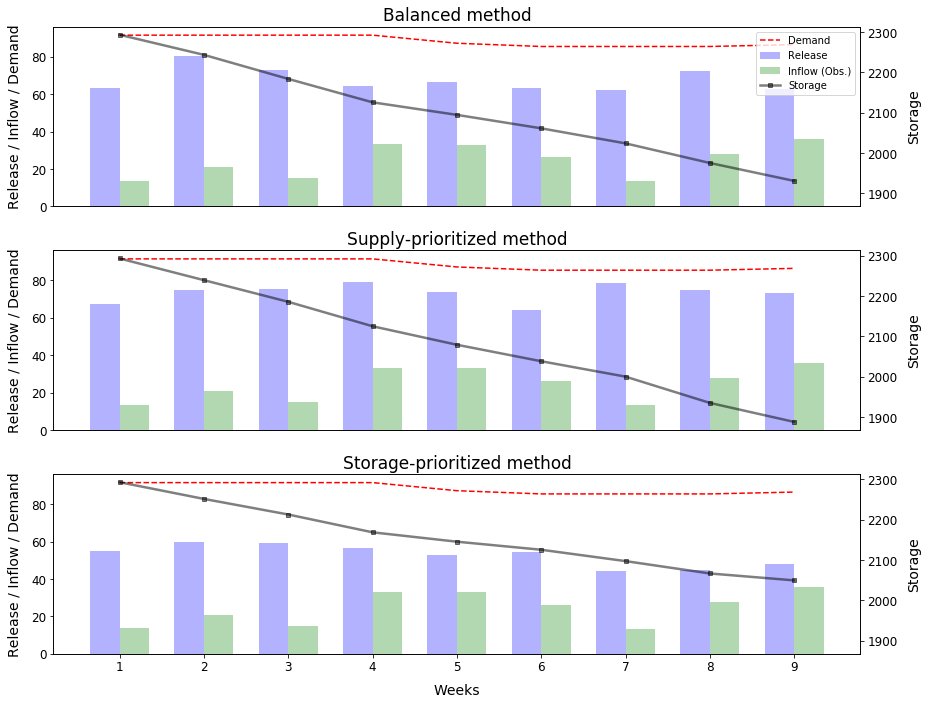

In [6]:
# Define scenario and MCDM method mappings
scenario = 1  # 1: Perfect forecast, 2: worst case, 3: 20-year drought, 4: ESP, 5: SFFs

# Mapping dictionary for different scenarios and MCDM methods
scenario_map = {1: 'resop_pf', 2: 'resop_wc', 3:'resop_d20', 4: 'resop_esp', 5: 'resop_sffs'}
mcdm_map = {1: '_bal', 2: '_sup', 3: '_sto', 4: '_ss', 5: '_mw', 6: '_up', 7: '_kp', 8: '_top'}

# Create a 3x1 subplot structure
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(13, 3.3 * 3))
bar_width = 0.35  # Width of the bars
index = np.arange(1, decision_time * 4 + 2)  # X-axis positions

# Initialize lists to store y-axis limits for each subplot
main_y_limits = []
aux_y_limits = []

# First subplot (Balanced method)
plt.subplot(3,1,1)
df = globals()[scenario_map[scenario] + mcdm_map[1]]  # Fetch the data for the Balanced method

ax1 = plt.gca()  # Get the current axis
# Plot bars for Release and Inflow (Obs.)
bar1 = ax1.bar(index - bar_width / 2, 
               pd.DataFrame(df)[df.index == 'Release'].iloc[1:decision_time*4+2, 0].reset_index(drop=True), 
               bar_width, label='Release', color='blue', alpha=0.3)
bar2 = ax1.bar(index + bar_width / 2, 
               pd.DataFrame(df)[df.index == 'I_obs'].iloc[1:decision_time*4+2, 0].reset_index(drop=True), 
               bar_width, label='Inflow (Obs.)', color='green', alpha=0.3)
# Plot line for Demand
line = ax1.plot(index, 
               pd.DataFrame(df)[df.index == 'Demand'].iloc[1:decision_time*4+2, 0].reset_index(drop=True), 
               label='Demand', color='red', linestyle='--')

ax1.set_xlabel(None)
ax1.set_ylabel('Release / Inflow / Demand', fontsize=14, labelpad=10)
ax1.set_xticks([])  # Remove x-ticks for the first plot
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)

# Save the main y-axis limit
main_y_limits.append(ax1.get_ylim())

# Plot Storage on the secondary y-axis
ax2 = ax1.twinx()
ax2.plot(index, 
         pd.DataFrame(df)[df.index == 'Storage'].iloc[0:decision_time*4+1, 0].reset_index(drop=True), 
         label='Storage', color='black', marker='s', lw=2.5, alpha=0.5, markersize=4)
ax2.set_ylabel('Storage', fontsize=14, labelpad=10)
plt.title('Balanced method', fontsize=17)
ax2.tick_params(axis='y', labelsize=12)

# Save the auxiliary y-axis limit
aux_y_limits.append(ax2.get_ylim())

# Combine legends from both axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')


# Second subplot (Supply-prioritized method)
plt.subplot(3,1,2)
df = globals()[scenario_map[scenario] + mcdm_map[2]]  # Fetch the data for the Supply-prioritized method

ax1 = plt.gca()
# Plot bars for Release and Inflow (Obs.)
bar1 = ax1.bar(index - bar_width / 2, 
               pd.DataFrame(df)[df.index == 'Release'].iloc[1:decision_time*4+2, 0].reset_index(drop=True), 
               bar_width, label='Release', color='blue', alpha=0.3)
bar2 = ax1.bar(index + bar_width / 2, 
               pd.DataFrame(df)[df.index == 'I_obs'].iloc[1:decision_time*4+2, 0].reset_index(drop=True), 
               bar_width, label='Inflow (Obs.)', color='green', alpha=0.3)
# Plot line for Demand
line = ax1.plot(index, 
               pd.DataFrame(df)[df.index == 'Demand'].iloc[1:decision_time*4+2, 0].reset_index(drop=True), 
               label='Demand', color='red', linestyle='--')
ax1.set_xlabel(None)
ax1.set_ylabel('Release / Inflow / Demand', fontsize=14, labelpad=10)
ax1.set_xticks([])  # Remove x-ticks for the second plot
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)

# Save the main y-axis limit
main_y_limits.append(ax1.get_ylim())

# Plot Storage on the secondary y-axis
ax2 = ax1.twinx()
ax2.plot(index, 
         pd.DataFrame(df)[df.index == 'Storage'].iloc[0:decision_time*4+1, 0].reset_index(drop=True), 
         label='Storage', color='black', marker='s', lw=2.5, alpha=0.5, markersize=4)
ax2.set_ylabel('Storage', fontsize=14, labelpad=10)
plt.title('Supply-prioritized method', fontsize=17)
ax2.tick_params(axis='y', labelsize=12)

# Save the auxiliary y-axis limit
aux_y_limits.append(ax2.get_ylim())


# Third subplot (Storage-prioritized method)
plt.subplot(3,1,3)
df = globals()[scenario_map[scenario] + mcdm_map[3]]  # Fetch the data for the Storage-prioritized method

ax1 = plt.gca()
# Plot bars for Release and Inflow (Obs.)
bar1 = ax1.bar(index - bar_width / 2, 
               pd.DataFrame(df)[df.index == 'Release'].iloc[1:decision_time*4+2, 0].reset_index(drop=True), 
               bar_width, label='Release', color='blue', alpha=0.3)
bar2 = ax1.bar(index + bar_width / 2, 
               pd.DataFrame(df)[df.index == 'I_obs'].iloc[1:decision_time*4+2, 0].reset_index(drop=True), 
               bar_width, label='Inflow (Obs.)', color='green', alpha=0.3)
# Plot line for Demand
line = ax1.plot(index, 
               pd.DataFrame(df)[df.index == 'Demand'].iloc[1:decision_time*4+2, 0].reset_index(drop=True), 
               label='Demand', color='red', linestyle='--')
ax1.set_ylabel('Release / Inflow / Demand', fontsize=14, labelpad=10)
ax1.set_xlabel('Weeks', fontsize=14, labelpad=10)
ax1.set_xticks(index)
ax1.tick_params(axis='x', labelsize=12)
ax1.tick_params(axis='y', labelsize=12)

# Save the main y-axis limit
main_y_limits.append(ax1.get_ylim())

# Plot Storage on the secondary y-axis
ax2 = ax1.twinx()
ax2.plot(index, 
         pd.DataFrame(df)[df.index == 'Storage'].iloc[0:decision_time*4+1, 0].reset_index(drop=True), 
         label='Storage', color='black', marker='s', lw=2.5, alpha=0.5, markersize=4)
ax2.set_ylabel('Storage', fontsize=14, labelpad=10)
plt.title('Storage-prioritized method', fontsize=17)
ax2.tick_params(axis='y', labelsize=12)

# Save the auxiliary y-axis limit
aux_y_limits.append(ax2.get_ylim())

# Set y-axis limits for all subplots to ensure consistency across plots
main_y_min = min([ylim[0] for ylim in main_y_limits])
main_y_max = max([ylim[1] for ylim in main_y_limits])
aux_y_min = min([ylim[0] for ylim in aux_y_limits])
aux_y_max = max([ylim[1] for ylim in aux_y_limits])

# Apply consistent y-axis limits across subplots
for ax in plt.gcf().axes:
    if ax.get_ylabel() == 'Release / Inflow / Demand':
        ax.set_ylim(main_y_min, main_y_max)
    if ax.get_ylabel() == 'Storage':
        ax.set_ylim(aux_y_min, aux_y_max)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### 3.2. Variable weighting method

This method uses same equation as SAW method but assigns different weights according to the storage volume at the time when the decision is taken. This method reproduces more closely the thought process of reservoir operators, who weight supply more when the storage is abundant and less when storage is scarce. We applied this method in two ways: the <b>‘simple selective’ (SS)</b> method, which adopts the same weights as in the SAW methods but varying them depending on storage status, and the <b>‘multi-weight’ (MW)</b> method, which applies more detailed procedure to allocate weights based on storage status. 
In doing so, we analysed around 20 years of historical storage records of A reservoir to divide the storage into multiple ranges, then specified a method or weight for each range (see the figure below).

![Variable_weighting](util/images/Variable_weighting.jpg)

In [7]:
# Sub function for Simple Selective method
def get_weight_ss(S_value):
    
    # Assign weights depending on predefined storage range for Simple Selective method
    weight_mapping = {
        (0, 2700): (1- weight_sto, weight_sto),            # Storage-prioritized
        (2700, 3300): (weight_bal, weight_bal),           # Balanced
        (3300, float('inf')): (1- weight_sup, weight_sup)  # Supply-prioritized
    }
    
    # Determine the appropriate weights based on the storage value (S_value)
    for range_tuple, weights in weight_mapping.items():
        if range_tuple[0] < S_value <= range_tuple[1]:
            return weights
    return (0.5, 0.5)  # Default weights if S_value is not in any predefined range

# Sub function for Multi-weighting method
def get_weight_mw(S_value):
    # Assign weights depending on predefined storage range for Multi-weighting method
    weight_mapping = {
        (0, 2500): (0.3, 0.7),
        (2500, 2750): (0.4, 0.6),
        (2750, 3000): (0.5, 0.5),
        (3000, 3250): (0.6, 0.4),
        (3250, 3500): (0.7, 0.3),
        (3500, float('inf')): (0.8, 0.2)
    }
    
    # Determine the appropriate weights based on the storage value (S_value)
    for range_tuple, weights in weight_mapping.items():
        if range_tuple[0] < S_value <= range_tuple[1]:
            return weights
    return (0.5, 0.5)  # Default weights if S_value is not in any predefined range


# Main function for Variable Weighting methods
def MCDM_VW_example(MCDM, year, month, reservoir_name, decision_time, leadtime):
    # Define file paths for different flow scenarios/forecasts
    path_pf = path + '/data/examples/' + scenario_list[1]   # Perfect forecast
    path_wc = path + '/data/examples/' + scenario_list[2]   # Worst-case
    path_d20 = path + '/data/examples/' + scenario_list[3] # 20-year return period drought
    path_esp = path + '/data/examples/' + scenario_list[4]  # ESP (Ensemble Streamflow Prediction)
    path_sffs = path + '/data/examples/' + scenario_list[5] # SFFs (Synthetic Flow Forecasts)
    obsdata = pd.read_csv(path + '/data/observed_data.csv',index_col = 'Date')
    ini_date = str(start_year) + '-' + str(start_month).zfill(2) + '-01'
    s_ini = obsdata[obsdata.index == ini_date].iloc[0,0]    

    # Read simulated Pareto front data for each flow scenario/forecast
    sim_pf = pd.read_csv(path_pf + '/[sim_pareto]' + str(reservoir_name) + '_' + str(year) + '_' + str(month) + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv', index_col=0)
    sim_wc = pd.read_csv(path_wc + '/[sim_pareto]' + str(reservoir_name) + '_' + str(year) + '_' + str(month) + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv', index_col=0)
    sim_d20 = pd.read_csv(path_d20 + '/[sim_pareto]' + str(reservoir_name) + '_' + str(year) + '_' + str(month) + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv', index_col=0)
    sim_esp = pd.read_csv(path_esp + '/[sim_pareto]' + str(reservoir_name) + '_' + str(year) + '_' + str(month) + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv', index_col=0)
    sim_sffs = pd.read_csv(path_sffs + '/[sim_pareto]' + str(reservoir_name) + '_' + str(year) + '_' + str(month) + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv', index_col=0)

    # Normalization of the simulated Pareto front data
    scaler = MinMaxScaler()
    sim_all = pd.concat([sim_pf, sim_wc, sim_d20, sim_esp, sim_sffs], axis=0)  # Combine data from all scenarios
    nor_all = pd.DataFrame(scaler.fit(sim_all).transform(sim_all)).rename({0: 'SSD', 1: 'SVD'}, axis=1)  # Normalize data
    nor_all['number'] = nor_all.index  # Add index column for identification
    nor_all['remark'] = 'Perfect forecast'  # Default remark for Perfect forecast scenario
    
    for i in range(len(nor_all)):
        if (nor_all['number'][i] >= 100) and (nor_all['number'][i] < 200):
            nor_all['remark'][i] = 'Worst-case'
            nor_all['number'][i] = nor_all['number'][i] - 100
        elif (nor_all['number'][i] >= 200) and (nor_all['number'][i] < 300):
            nor_all['remark'][i] = '20-year drought'
            nor_all['number'][i] = nor_all['number'][i] - 200
        elif (nor_all['number'][i] >= 300) and (nor_all['number'][i] < 400):
            nor_all['remark'][i] = 'ESP'
            nor_all['number'][i] = nor_all['number'][i] - 300
        elif (nor_all['number'][i] >= 400) and (nor_all['number'][i] < 500):
            nor_all['remark'][i] = 'SFFs'
            nor_all['number'][i] = nor_all['number'][i] - 400

    def calculate_scores_vm(year, month, scenario, df):
        if year == start_year and month == start_month:
            S_value = s_ini
        elif scenario == 1:
            S_value = S_all['S_pf'].iloc[-1, :][0]
        elif scenario == 2:
            S_value = S_all['S_wc'].iloc[-1, :][0]
        elif scenario == 3:
            S_value = S_all['S_d20'].iloc[-1, :][0]
        elif scenario == 4:
            S_value = S_all['S_esp'].iloc[-1, :][0]
        elif scenario == 5:
            S_value = S_all['S_sffs'].iloc[-1, :][0]
        else:
            drop

        if MCDM == 4:
            w_ssd, w_svd = get_weight_ss(S_value)
        elif MCDM == 5:
            w_ssd, w_svd = get_weight_mw(S_value)
        else:
            drop

        df['score'] = abs(df['SSD'] * w_ssd + df['SVD'] * w_svd)
        return df

    # Apply the scoring function to each scenario
    nor_pf = nor_all[nor_all.remark == 'Perfect forecast']
    nor_pf = calculate_scores_vm(year, month, scenario, nor_pf)
    opt_num_pf = nor_pf[(nor_pf['score'] == nor_pf['score'].min())].index[0]

    nor_wc = nor_all[nor_all.remark == 'Worst-case']
    nor_wc = calculate_scores_vm(year, month, scenario, nor_wc)
    opt_num_wc = nor_wc[(nor_wc['score'] == nor_wc['score'].min())].index[0]

    nor_d20 = nor_all[nor_all.remark == '20-year drought']
    nor_d20 = calculate_scores_vm(year, month, scenario, nor_d20)
    opt_num_d20 = nor_d20[(nor_d20['score'] == nor_d20['score'].min())].index[0]

    nor_esp = nor_all[nor_all.remark == 'ESP']
    nor_esp = calculate_scores_vm(year, month, scenario, nor_esp)
    opt_num_esp = nor_esp[(nor_esp['score'] == nor_esp['score'].min())].index[0]

    nor_sffs = nor_all[nor_all.remark == 'SFFs']
    nor_sffs = calculate_scores_vm(year, month, scenario, nor_sffs)
    opt_num_sffs = nor_sffs[(nor_sffs['score'] == nor_sffs['score'].min())].index[0]
    
    # Read and prepare the data for output for each scenario
    pf = pd.read_csv(path_pf + '/[Res_operation]' + str(reservoir_name) + '_' + str(year) + '_' + str(month) + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv', index_col=0)
    resop_pf = pf[str(opt_num_pf)]
    S_pf = pd.DataFrame(pf[str(opt_num_pf)].loc['Storage'])[:].rename(columns={str(opt_num_pf): 'S_pf'})[:decision_time * 4 + 1]

    wc = pd.read_csv(path_wc + '/[Res_operation]' + str(reservoir_name) + '_' + str(year) + '_' + str(month) + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv', index_col=0)
    resop_wc = wc[str(opt_num_wc)]
    S_wc = pd.DataFrame(wc[str(opt_num_wc)].loc['Storage'])[:].rename(columns={str(opt_num_wc): 'S_wc'})[:decision_time * 4 + 1]

    d20 = pd.read_csv(path_d20 + '/[Res_operation]' + str(reservoir_name) + '_' + str(year) + '_' + str(month) + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv', index_col=0)
    resop_d20 = d20[str(opt_num_d20)]
    S_d20 = pd.DataFrame(d20[str(opt_num_d20)].loc['Storage'])[:].rename(columns={str(opt_num_d20): 'S_d20'})[:decision_time * 4 + 1]
    
    esp = pd.read_csv(path_esp + '/[Res_operation]' + str(reservoir_name) + '_' + str(year) + '_' + str(month) + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv', index_col=0)
    resop_esp = esp[str(opt_num_esp)]
    S_esp = pd.DataFrame(esp[str(opt_num_esp)].loc['Storage'])[:].rename(columns={str(opt_num_esp): 'S_esp'})[:decision_time * 4 + 1]

    sffs = pd.read_csv(path_sffs + '/[Res_operation]' + str(reservoir_name) + '_' + str(year) + '_' + str(month) + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv', index_col=0)
    resop_sffs = sffs[str(opt_num_sffs)]
    S_sffs = pd.DataFrame(sffs[str(opt_num_sffs)].loc['Storage'])[:].rename(columns={str(opt_num_sffs): 'S_sffs'})[:decision_time * 4 + 1]

    # Concatenate all storage data into a single DataFrame
    S_all = pd.concat([S_pf, S_wc, S_d20, S_esp, S_sffs], axis=1).reset_index(drop=True)
    
    return S_all, resop_pf, resop_wc, resop_d20, resop_esp, resop_sffs

#### - Run MCDM_VW Function (Variable Weighting method)

In [8]:
year = start_year
month = start_month

# Dictionary to store the results of MCDM_VW_example function calls for different MCDM values
results = {}

# Loop through different MCDM methods (4: Simple Selective, 5: Multi-Weighting)
for MCDM in [4, 5]:
    # Call MCDM_VW_example function for each MCDM method and store the results in the 'results' dictionary
    results[MCDM] = MCDM_VW_example(MCDM, year, month, reservoir_name, decision_time, leadtime)

# Extract results for the Simple Selective method (MCDM 4), Multi-Weighting method (MCDM 5)
S_all_ss, resop_pf_ss, resop_wc_ss, resop_d20_ss, resop_esp_ss, resop_sffs_ss = results[4]
S_all_mw, resop_pf_mw, resop_wc_mw, resop_d20_mw, resop_esp_mw, resop_sffs_mw = results[5]

#### - Visualisation of decision-making results (Variable Weighting method)

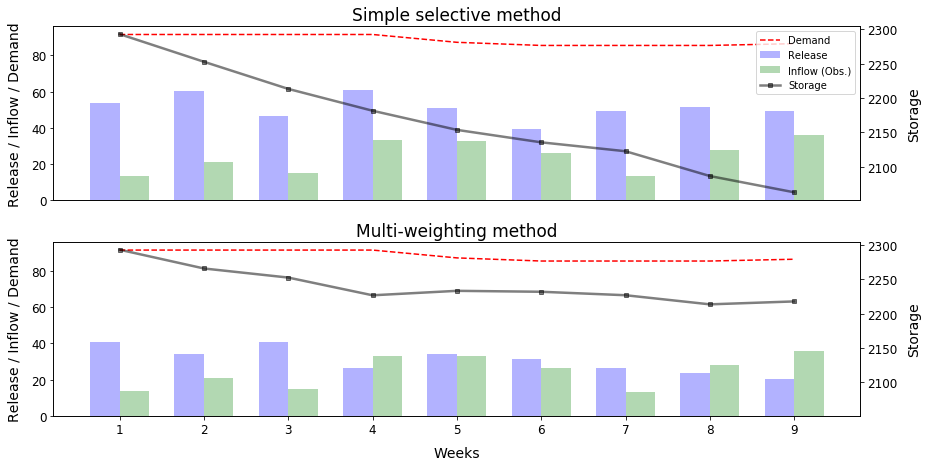

In [9]:
# Scenario selection 
scenario = 3  # 1: Perfect forecast, 2: worst case, 3: 20-year drought, 4: ESP, 5: SFFs

# Mapping setup for scenario and MCDM methods
scenario_map = {1: 'resop_pf', 2: 'resop_wc', 3:'resop_d20', 4: 'resop_esp', 5: 'resop_sffs'}
mcdm_map = {1: '_bal', 2: '_sup', 3: '_sto', 4: '_ss', 5: '_mw', 6: '_up', 7: '_kp', 8: '_top'}

# Create subplots (2 rows, 1 column), sharing x and y axes
fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(13, 3.3 * 2))

# Set bar width for bar plots
bar_width = 0.35  
# Set x-axis positions for the bars based on the decision time
index = np.arange(1, decision_time * 4 + 2)

# Initialize lists to collect y-axis limits for all subplots
main_y_limits = []
aux_y_limits = []

# First subplot for Simple Selective Method
plt.subplot(2,1,1)
df = globals()[scenario_map[scenario] + mcdm_map[4]]  # Get the data for the selected scenario and method

# Plot bars for Release and Inflow, and a line for Demand
ax1 = plt.gca()
bar1 = ax1.bar(index - bar_width / 2, 
               pd.DataFrame(df)[df.index == 'Release'].iloc[1:decision_time*4+2, 0].reset_index(drop=True), 
               bar_width, label='Release', color='blue', alpha=0.3)
bar2 = ax1.bar(index + bar_width / 2, 
               pd.DataFrame(df)[df.index == 'I_obs'].iloc[1:decision_time*4+2, 0].reset_index(drop=True), 
               bar_width, label='Inflow (Obs.)', color='green', alpha=0.3)
line = ax1.plot(index, 
               pd.DataFrame(df)[df.index == 'Demand'].iloc[1:decision_time*4+2, 0].reset_index(drop=True), 
               label='Demand', color='red', linestyle='--')

# Set y-axis label for the first y-axis (left)
ax1.set_ylabel('Release / Inflow / Demand', fontsize=14, labelpad=10)
ax1.set_xticks([])  # Hide x-axis ticks for the first subplot
ax1.tick_params(axis='x', labelsize=12)  # Set font size for x-axis ticks
ax1.tick_params(axis='y', labelsize=12)  # Set font size for y-axis ticks

# Save the y-axis limits for the first axis (Release / Inflow / Demand)
main_y_limits.append(ax1.get_ylim())

# Create a secondary y-axis (right) for Storage
ax2 = ax1.twinx()
ax2.plot(index, 
         pd.DataFrame(df)[df.index == 'Storage'].iloc[0:decision_time*4+1, 0].reset_index(drop=True), 
         label='Storage', color='black', marker='s', lw=2.5, alpha=0.5, markersize=4)
ax2.set_ylabel('Storage', fontsize=14, labelpad=10)
plt.title('Simple selective method', fontsize=17)  # Title for the first subplot
ax2.tick_params(axis='y', labelsize=12)  # Set font size for y-axis ticks (Storage)

# Save the y-axis limits for the second axis (Storage)
aux_y_limits.append(ax2.get_ylim())

# Integrate legends for both axes
lines, labels = ax1.get_legend_handles_labels()  # Get legend handles and labels from ax1
lines2, labels2 = ax2.get_legend_handles_labels()  # Get legend handles and labels from ax2
ax1.legend(lines + lines2, labels + labels2, loc='upper right')  # Combine and display the legend


# Second subplot for Multi-weighting Method
plt.subplot(2,1,2)
df = globals()[scenario_map[scenario] + mcdm_map[5]]  # Get the data for the selected scenario and method

# Plot bars for Release and Inflow, and a line for Demand
ax1 = plt.gca()
bar1 = ax1.bar(index - bar_width / 2, 
               pd.DataFrame(df)[df.index == 'Release'].iloc[1:decision_time*4+2, 0].reset_index(drop=True), 
               bar_width, label='Release', color='blue', alpha=0.3)
bar2 = ax1.bar(index + bar_width / 2, 
               pd.DataFrame(df)[df.index == 'I_obs'].iloc[1:decision_time*4+2, 0].reset_index(drop=True), 
               bar_width, label='Inflow (Obs.)', color='green', alpha=0.3)
line = ax1.plot(index, 
               pd.DataFrame(df)[df.index == 'Demand'].iloc[1:decision_time*4+2, 0].reset_index(drop=True), 
               label='Demand', color='red', linestyle='--')

# Set y-axis label for the first y-axis (left)
ax1.set_ylabel('Release / Inflow / Demand', fontsize=14, labelpad=10)
ax1.set_xlabel('Weeks', fontsize=14, labelpad=10)
ax1.set_xticks(index)
ax1.tick_params(axis='x', labelsize=12)  # Set font size for x-axis ticks
ax1.tick_params(axis='y', labelsize=12)  # Set font size for y-axis ticks

# Save the y-axis limits for the first axis (Release / Inflow / Demand)
main_y_limits.append(ax1.get_ylim())

# Create a secondary y-axis (right) for Storage
ax2 = ax1.twinx()
ax2.plot(index, 
         pd.DataFrame(df)[df.index == 'Storage'].iloc[0:decision_time*4+1, 0].reset_index(drop=True), 
         label='Storage', color='black', marker='s', lw=2.5, alpha=0.5, markersize=4)
ax2.set_ylabel('Storage', fontsize=14, labelpad=10)
plt.title('Multi-weighting method', fontsize=17)  # Title for the second subplot
ax2.tick_params(axis='y', labelsize=12)  # Set font size for y-axis ticks (Storage)

# Save the y-axis limits for the second axis (Storage)
aux_y_limits.append(ax2.get_ylim())

# Adjust the y-axis limits for all subplots to be consistent
main_y_min = min([ylim[0] for ylim in main_y_limits])  # Get the minimum y-limit for the main axis
main_y_max = max([ylim[1] for ylim in main_y_limits])  # Get the maximum y-limit for the main axis
aux_y_min = min([ylim[0] for ylim in aux_y_limits])  # Get the minimum y-limit for the auxiliary axis
aux_y_max = max([ylim[1] for ylim in aux_y_limits])  # Get the maximum y-limit for the auxiliary axis

# Apply consistent y-limits to all axes in the figure
for ax in plt.gcf().axes:
    if ax.get_ylabel() == 'Release / Inflow / Demand':
        ax.set_ylim(main_y_min, main_y_max)
    if ax.get_ylabel() == 'Storage':
        ax.set_ylim(aux_y_min, aux_y_max)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### 3.3. Reference point method

This method identifies the compromise solution on a Pareto front by measuring the distance from a reference point. In this study, we applied three versions of this approach: <b>‘utopian point’ (UP)</b>, <b>‘knee point’ (KP)</b>, and <b>‘TOPSIS’ (TOP)</b> methods. Application examples of these methods are illustrated in the figure below. 

The utopian point method selects the solution on the Pareto front that minimizes the Euclidean distance from the utopian (or ideal) point, which represents the theoretical perfect solution (Lu et al., 2011). 
The **Compromise Solution** using the Utopian point method can be expressed as:


$$
\text{Compromise Solution}_{\text{Utopian}} = \min \left( \sqrt{ (\text{SSD}_i - \text{SSD}_{\text{utopian}})^2 + (\text{SVD}_i - \text{SVD}_{\text{utopian}})^2 } \right)
$$

The knee point method selects the knee point, which is a point where the curvature of the Pareto front is maximum (Das, 1999). Among various methods for detecting the knee point, we adopted the approach based on Minimum Manhattan Distance from the utopian point (Chiu et al., 2016). This approach has been demonstrated to be both simple and robust in the literature (Li et al., 2020). Compromise solutions from these two methods are computed as:

$$
\text{Compromise Solution}_{\text{Knee}} = \min \left( \left| \text{SSD}_i - \text{SSD}_{\text{utopian}} \right| + \left| \text{SVD}_i - \text{SVD}_{\text{utopian}} \right| \right)
$$

where i=1,…,100 is the number of points (each corresponding to a Pareto-optimal release schedule) on the Pareto front. ${SSD}_i$ and $SVD_i$ denote a normalized point of each objective at the ith point (see Eqs. 5 and 6 in main manuscript). $SSD_{utopia}$ and $SVD_{utopia}$ are the utopian points of each objective, which are equal to [0, 0].


The TOPSIS method, developed by Hwang and Yoon (1981), is a widely chosen method for MCDM (Tzeng and Huang, 2011; Wang and Rangaiah, 2017) and is recommended by the United Nations Environmental Program (Chen, 2000; Zhu et al., 2015). It selects a point with the shortest Euclidian distance from the ideal point [0, 0] and the longest distance from the anti-ideal point [1, 1] as the compromise solution (Hwang and Yoon, 1981; Liu, 2009). This can be expressed as:

$$
\text{Distance}_{i}^{\text{ideal}} = \sqrt{ \left( \text{SSD}_i - \text{SSD}_{\text{ideal}} \right)^2 + \left( \text{SVD}_i - \text{SVD}_{\text{ideal}} \right)^2 }
$$

$$
\text{Distance}_{i}^{\text{anti-ideal}} = \sqrt{ \left( \text{SSD}_{\text{anti-ideal}} - \text{SSD}_i \right)^2 + \left( \text{SVD}_{\text{anti-ideal}} - \text{SVD}_i \right)^2 }
$$

$$
\text{CC}_i = \frac{\text{Distance}_{i}^{\text{anti-ideal}}}{\text{Distance}_{i}^{\text{ideal}} + \text{Distance}_{i}^{\text{anti-ideal}}}
$$

where $Distance_i^{ideal}$ and $Distance_i^{anti-ideal}$ are the Euclidian distances from ideal and anti-ideal points from ith point, and $CC_i$ is the closeness coefficient of the ith point. Since a higher closeness coefficient indicates a better solution, the point with the highest $CC_i$ is selected as the compromise solution. 



![reference method](util/images/reference_point.jpg)

In [10]:
# Main function for Reference Point methods
def MCDM_RP_example(MCDM, year, month, reservoir_name, decision_time, leadtime):
    # Define file paths for different flow scenarios/forecasts
    path_pf = path + '/data/examples/' + scenario_list[1]   # Perfect forecast
    path_wc = path + '/data/examples/' + scenario_list[2]   # Worst-case
    path_d20 = path + '/data/examples/' + scenario_list[3] # 20-year return period drought
    path_esp = path + '/data/examples/' + scenario_list[4]  # ESP (Ensemble Streamflow Prediction)
    path_sffs = path + '/data/examples/' + scenario_list[5] # SFFs (Synthetic Flow Forecasts)

    # Read simulated Pareto front data for each flow scenario/forecast
    sim_pf = pd.read_csv(path_pf + '/[sim_pareto]' + str(reservoir_name) + '_' + str(year) + '_' + str(month) + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv', index_col=0)
    sim_wc = pd.read_csv(path_wc + '/[sim_pareto]' + str(reservoir_name) + '_' + str(year) + '_' + str(month) + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv', index_col=0)
    sim_d20 = pd.read_csv(path_d20 + '/[sim_pareto]' + str(reservoir_name) + '_' + str(year) + '_' + str(month) + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv', index_col=0)
    sim_esp = pd.read_csv(path_esp + '/[sim_pareto]' + str(reservoir_name) + '_' + str(year) + '_' + str(month) + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv', index_col=0)
    sim_sffs = pd.read_csv(path_sffs + '/[sim_pareto]' + str(reservoir_name) + '_' + str(year) + '_' + str(month) + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv', index_col=0)

    # Normalization of the simulated Pareto front data
    scaler = MinMaxScaler()
    sim_all = pd.concat([sim_pf, sim_wc, sim_d20, sim_esp, sim_sffs], axis=0)  # Combine data from all scenarios
    nor_all = pd.DataFrame(scaler.fit(sim_all).transform(sim_all)).rename({0: 'SSD', 1: 'SVD'}, axis=1)  # Normalize data
    nor_all['number'] = nor_all.index  # Add index column for identification
    nor_all['remark'] = 'Perfect forecast'  # Default remark for Perfect forecast scenario
    
    # Adjust 'remark' and 'number' columns based on scenario index ranges
    for i in range(len(nor_all)):
        if (nor_all['number'][i] >= 100) and (nor_all['number'][i] < 200):
            nor_all['remark'][i] = 'Worst-case'
            nor_all['number'][i] = nor_all['number'][i] - 100
        elif (nor_all['number'][i] >= 200) and (nor_all['number'][i] < 300):
            nor_all['remark'][i] = '20-year drought'
            nor_all['number'][i] = nor_all['number'][i] - 200
        elif (nor_all['number'][i] >= 300) and (nor_all['number'][i] < 400):
            nor_all['remark'][i] = 'ESP'
            nor_all['number'][i] = nor_all['number'][i] - 300
        elif (nor_all['number'][i] >= 400) and (nor_all['number'][i] < 500):
            nor_all['remark'][i] = 'SFFs'
            nor_all['number'][i] = nor_all['number'][i] - 400

    # Compute the optimal reference point for the Perfect Forecast scenario
    nor_pf = nor_all[nor_all.remark == 'Perfect forecast']
    if MCDM == 6:
        # Euclidean distance
        nor_pf['distance'] = abs(nor_pf['SSD']**2 + nor_pf['SVD']**2)**0.5
        opt_num_pf = nor_pf[(nor_pf['distance'] == nor_pf['distance'].min())].index[0]
    elif MCDM == 7:
        # Manhattan distance
        nor_pf['distance'] = abs(nor_pf['SSD'] + nor_pf['SVD'])
        opt_num_pf = nor_pf[(nor_pf['distance'] == nor_pf['distance'].min())].index[0]
    elif MCDM == 8:
        # Relative closeness to the ideal point
        nor_pf['distance+'] = abs(nor_pf['SSD']**2 + nor_pf['SVD']**2)**0.5
        nor_pf['distance-'] = abs((1-nor_pf['SSD'])**2 + (1-nor_pf['SVD'])**2)**0.5
        nor_pf['R_wc'] = nor_pf['distance-'] / (nor_pf['distance-']+nor_pf['distance+'])
        opt_num_pf = nor_pf[(nor_pf['R_wc'] == nor_pf['R_wc'].max())].index[0]
    else:
        drop
    
    # Compute the optimal reference point for the Worst-case scenario
    nor_wc = nor_all[nor_all.remark == 'Worst-case']    
    if MCDM == 6:
        # Euclidean distance
        nor_wc['distance'] = abs(nor_wc['SSD']**2 + nor_wc['SVD']**2)**0.5
        opt_num_wc = nor_wc[(nor_wc['distance'] == nor_wc['distance'].min())].index[0]
    elif MCDM == 7:
        # Manhattan distance
        nor_wc['distance'] = abs(nor_wc['SSD'] + nor_wc['SVD'])
        opt_num_wc = nor_wc[(nor_wc['distance'] == nor_wc['distance'].min())].index[0]
    elif MCDM == 8:
        # Relative closeness to the ideal point
        nor_wc['distance+'] = abs(nor_wc['SSD']**2 + nor_wc['SVD']**2)**0.5
        nor_wc['distance-'] = abs((1-nor_wc['SSD'])**2 + (1-nor_wc['SVD'])**2)**0.5
        nor_wc['R_wc'] = nor_wc['distance-'] / (nor_wc['distance-']+nor_wc['distance+'])
        opt_num_wc = nor_wc[(nor_wc['R_wc'] == nor_wc['R_wc'].max())].index[0]
    else:
        drop
        
    # Compute the optimal reference point for the 20 year return period drought scenario
    nor_d20 = nor_all[nor_all.remark == 'Worst-case']    
    if MCDM == 6:
        nor_d20['distance'] = abs(nor_d20['SSD']**2 + nor_d20['SVD']**2)**0.5
        opt_num_d20 = nor_d20[(nor_d20['distance'] == nor_d20['distance'].min())].index[0]
    elif MCDM == 7:
        nor_d20['distance'] = abs(nor_d20['SSD'] + nor_d20['SVD'])
        opt_num_d20 = nor_d20[(nor_d20['distance'] == nor_d20['distance'].min())].index[0]
    elif MCDM == 8:
        nor_d20['distance+'] = abs(nor_d20['SSD']**2 + nor_d20['SVD']**2)**0.5
        nor_d20['distance-'] = abs((1-nor_d20['SSD'])**2 + (1-nor_d20['SVD'])**2)**0.5
        nor_d20['R_d20'] = nor_d20['distance-'] / (nor_d20['distance-']+nor_d20['distance+'])
        opt_num_d20 = nor_d20[(nor_d20['R_d20'] == nor_d20['R_d20'].max())].index[0]
    else:
        drop        
        
    # Compute the optimal reference point for the ESP
    nor_esp = nor_all[nor_all.remark == 'ESP']
    if MCDM == 6:
        # Euclidean distance
        nor_esp['distance'] = abs(nor_esp['SSD']**2 + nor_esp['SVD']**2)**0.5
        opt_num_esp = nor_esp[(nor_esp['distance'] == nor_esp['distance'].min())].index[0]
    elif MCDM == 7:
        # Manhattan distance
        nor_esp['distance'] = abs(nor_esp['SSD'] + nor_esp['SVD'])
        opt_num_esp = nor_esp[(nor_esp['distance'] == nor_esp['distance'].min())].index[0]
    elif MCDM == 8:
        # Relative closeness to the ideal point
        nor_esp['distance+'] = abs(nor_esp['SSD']**2 + nor_esp['SVD']**2)**0.5
        nor_esp['distance-'] = abs((1-nor_esp['SSD'])**2 + (1-nor_esp['SVD'])**2)**0.5
        nor_esp['R_esp'] = nor_esp['distance-'] / (nor_esp['distance-']+nor_esp['distance+'])
        opt_num_esp = nor_esp[(nor_esp['R_esp'] == nor_esp['R_esp'].max())].index[0]
    else:
        drop        

    # Compute the optimal reference point for the SFFs
    nor_sffs = nor_all[nor_all.remark == 'SFFs']
    if MCDM == 6:
        # Euclidean distance
        nor_sffs['distance'] = abs(nor_sffs['SSD']**2 + nor_sffs['SVD']**2)**0.5
        opt_num_sffs = nor_sffs[(nor_sffs['distance'] == nor_sffs['distance'].min())].index[0]
    elif MCDM == 7:
        # Manhattan distance
        nor_sffs['distance'] = abs(nor_sffs['SSD'] + nor_sffs['SVD'])
        opt_num_sffs = nor_sffs[(nor_sffs['distance'] == nor_sffs['distance'].min())].index[0]
    elif MCDM == 8:
        # Relative closeness to the ideal point
        nor_sffs['distance+'] = abs(nor_sffs['SSD']**2 + nor_sffs['SVD']**2)**0.5
        nor_sffs['distance-'] = abs((1-nor_sffs['SSD'])**2 + (1-nor_sffs['SVD'])**2)**0.5
        nor_sffs['R_sffs'] = nor_sffs['distance-'] / (nor_sffs['distance-']+nor_sffs['distance+'])
        opt_num_sffs = nor_sffs[(nor_sffs['R_sffs'] == nor_sffs['R_sffs'].max())].index[0]
    else:
        drop        
    
    # Read and prepare the data for output for each scenario
    pf = pd.read_csv(path_pf + '/[Res_operation]' + str(reservoir_name) + '_' + str(year) + '_' + str(month) + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv', index_col=0)
    resop_pf = pf[str(opt_num_pf)]
    S_pf = pd.DataFrame(pf[str(opt_num_pf)].loc['Storage'])[:].rename(columns={str(opt_num_pf): 'S_pf'})[:decision_time * 4 + 1]

    wc = pd.read_csv(path_wc + '/[Res_operation]' + str(reservoir_name) + '_' + str(year) + '_' + str(month) + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv', index_col=0)
    resop_wc = wc[str(opt_num_wc)]
    S_wc = pd.DataFrame(wc[str(opt_num_wc)].loc['Storage'])[:].rename(columns={str(opt_num_wc): 'S_wc'})[:decision_time * 4 + 1]

    d20 = pd.read_csv(path_d20 + '/[Res_operation]' + str(reservoir_name) + '_' + str(year) + '_' + str(month) + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv', index_col=0)
    resop_d20 = d20[str(opt_num_d20)]
    S_d20 = pd.DataFrame(d20[str(opt_num_d20)].loc['Storage'])[:].rename(columns={str(opt_num_d20): 'S_d20'})[:decision_time * 4 + 1]
    
    esp = pd.read_csv(path_esp + '/[Res_operation]' + str(reservoir_name) + '_' + str(year) + '_' + str(month) + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv', index_col=0)
    resop_esp = esp[str(opt_num_esp)]
    S_esp = pd.DataFrame(esp[str(opt_num_esp)].loc['Storage'])[:].rename(columns={str(opt_num_esp): 'S_esp'})[:decision_time * 4 + 1]

    sffs = pd.read_csv(path_sffs + '/[Res_operation]' + str(reservoir_name) + '_' + str(year) + '_' + str(month) + '_decision_' + str(decision_time) + 'm_' + MCDM_list[MCDM] + '.csv', index_col=0)
    resop_sffs = sffs[str(opt_num_sffs)]
    S_sffs = pd.DataFrame(sffs[str(opt_num_sffs)].loc['Storage'])[:].rename(columns={str(opt_num_sffs): 'S_sffs'})[:decision_time * 4 + 1]

    # Concatenate all storage data into a single DataFrame
    S_all = pd.concat([S_pf, S_wc, S_d20, S_esp, S_sffs], axis=1).reset_index(drop=True)
    
    return S_all, resop_pf, resop_wc, resop_d20, resop_esp, resop_sffs

#### - Run MCDM_RF Function (Reference Point method)

In [11]:
year = start_year
month = start_month

# Dictionary to store the results of MCDM_RF_example function calls for different MCDM values
results = {}

# Loop through different MCDM methods (6: Utopian Point, 7: Knee point, 8: TOPSIS)
for MCDM in [6, 7, 8]:
    # Call MCDM__RF_example function for each MCDM method and store the results in the 'results' dictionary
    results[MCDM] = MCDM_RP_example(MCDM, year, month, reservoir_name, decision_time, leadtime)

# Extract results for the Utopian Point method (MCDM:6), Knee point method (MCDM:7) and TOPSIS method (MCDM:8)
S_all_up, resop_pf_up, resop_wc_up, resop_d20_up, resop_esp_up, resop_sffs_up = results[6]
S_all_kp, resop_pf_kp, resop_wc_kp, resop_d20_kp, resop_esp_kp, resop_sffs_kp = results[7]
S_all_top, resop_pf_top, resop_wc_top, resop_d20_top, resop_esp_top, resop_sffs_top = results[8]

#### - Visualisation of decision-making results (Reference Point method)

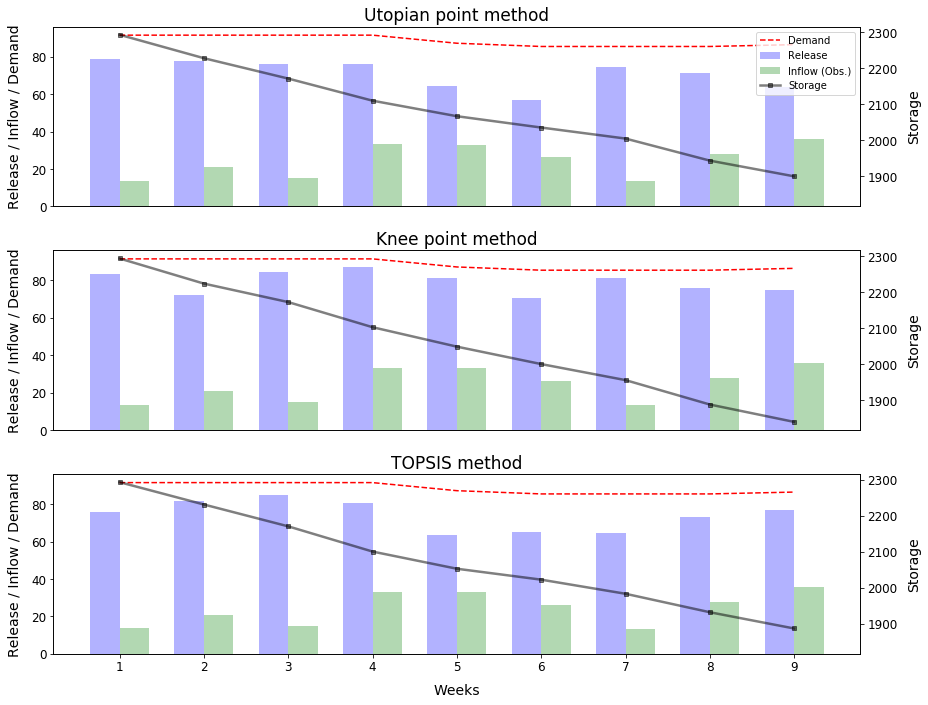

In [12]:
# Scenario and MCDM method mappings
scenario = 4  # 1: Perfect forecast, 2: worst case, 3: 20-year drought, 4: ESP, 5: SFFs
scenario_map = {1: 'resop_pf', 2: 'resop_wc', 3:'resop_d20', 4: 'resop_esp', 5: 'resop_sffs'}
mcdm_map = {1: '_bal', 2: '_sup', 3: '_sto', 4: '_ss', 5: '_mw', 6: '_up', 7: '_kp', 8: '_top'}

# Create subplots
fig, axes = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(13, 3.3 * 3))
bar_width = 0.35  # Width of bars in the bar chart
index = np.arange(1, decision_time * 4 + 2)  # x-axis positions for bars

# Initialize lists to store y-axis limits for the plots
main_y_limits = []
aux_y_limits = []

# First subplot (Utopian point method)
plt.subplot(3, 1, 1)
df = globals()[scenario_map[scenario] + mcdm_map[6]]  # Access DataFrame for the given scenario and MCDM method

# Plot the bars and lines for the first subplot
ax1 = plt.gca()
bar1 = ax1.bar(index - bar_width / 2, 
               pd.DataFrame(df)[df.index == 'Release'].iloc[1:decision_time*4+2, 0].reset_index(drop=True), 
               bar_width, label='Release', color='blue', alpha=0.3)
bar2 = ax1.bar(index + bar_width / 2, 
               pd.DataFrame(df)[df.index == 'I_obs'].iloc[1:decision_time*4+2, 0].reset_index(drop=True), 
               bar_width, label='Inflow (Obs.)', color='green', alpha=0.3)
line = ax1.plot(index, 
               pd.DataFrame(df)[df.index == 'Demand'].iloc[1:decision_time*4+2, 0].reset_index(drop=True), 
               label='Demand', color='red', linestyle='--')

ax1.set_xlabel(None)
ax1.set_ylabel('Release / Inflow / Demand', fontsize=14, labelpad=10)
ax1.set_xticks([])
ax1.tick_params(axis='x', labelsize=12)  # Set x-axis font size
ax1.tick_params(axis='y', labelsize=12)  # Set y-axis font size

# Save the y-axis limits for this plot
main_y_limits.append(ax1.get_ylim())

# Create a twin axis for plotting storage
ax2 = ax1.twinx()
ax2.plot(index, 
         pd.DataFrame(df)[df.index == 'Storage'].iloc[0:decision_time*4+1, 0].reset_index(drop=True), 
         label='Storage', color='black', marker='s', lw=2.5, alpha=0.5, markersize=4)
ax2.set_ylabel('Storage', fontsize=14, labelpad=10)
plt.title('Utopian point method', fontsize=17)
ax2.tick_params(axis='y', labelsize=12)  # Set y-axis font size (for Storage)

# Save the y-axis limits for the twin axis
aux_y_limits.append(ax2.get_ylim())

# Integrate legends for both axes
lines, labels = ax1.get_legend_handles_labels()  # Get legend handles and labels for ax1
lines2, labels2 = ax2.get_legend_handles_labels()  # Get legend handles and labels for ax2
ax1.legend(lines + lines2, labels + labels2, loc='upper right')  # Combine and display legends

# Second subplot (Knee point method)
plt.subplot(3, 1, 2)
df = globals()[scenario_map[scenario] + mcdm_map[7]]  # Access DataFrame for the given scenario and MCDM method

# Plot the bars and lines for the second subplot
ax1 = plt.gca()
bar1 = ax1.bar(index - bar_width / 2, 
               pd.DataFrame(df)[df.index == 'Release'].iloc[1:decision_time*4+2, 0].reset_index(drop=True), 
               bar_width, label='Release', color='blue', alpha=0.3)
bar2 = ax1.bar(index + bar_width / 2, 
               pd.DataFrame(df)[df.index == 'I_obs'].iloc[1:decision_time*4+2, 0].reset_index(drop=True), 
               bar_width, label='Inflow (Obs.)', color='green', alpha=0.3)
line = ax1.plot(index, 
               pd.DataFrame(df)[df.index == 'Demand'].iloc[1:decision_time*4+2, 0].reset_index(drop=True), 
               label='Demand', color='red', linestyle='--')
ax1.set_xlabel(None)
ax1.set_ylabel('Release / Inflow / Demand', fontsize=14, labelpad=10)
ax1.set_xticks([])
ax1.tick_params(axis='x', labelsize=12)  # Set x-axis font size
ax1.tick_params(axis='y', labelsize=12)  # Set y-axis font size

# Save the y-axis limits for this plot
main_y_limits.append(ax1.get_ylim())

# Create a twin axis for plotting storage
ax2 = ax1.twinx()
ax2.plot(index, 
         pd.DataFrame(df)[df.index == 'Storage'].iloc[0:decision_time*4+1, 0].reset_index(drop=True), 
         label='Storage', color='black', marker='s', lw=2.5, alpha=0.5, markersize=4)
ax2.set_ylabel('Storage', fontsize=14, labelpad=10)
plt.title('Knee point method', fontsize=17)
ax2.tick_params(axis='y', labelsize=12)  # Set y-axis font size (for Storage)

# Save the y-axis limits for the twin axis
aux_y_limits.append(ax2.get_ylim())

# Third subplot (TOPSIS method)
plt.subplot(3, 1, 3)
df = globals()[scenario_map[scenario] + mcdm_map[8]]  # Access DataFrame for the given scenario and MCDM method

# Plot the bars and lines for the third subplot
ax1 = plt.gca()
bar1 = ax1.bar(index - bar_width / 2, 
               pd.DataFrame(df)[df.index == 'Release'].iloc[1:decision_time*4+2, 0].reset_index(drop=True), 
               bar_width, label='Release', color='blue', alpha=0.3)
bar2 = ax1.bar(index + bar_width / 2, 
               pd.DataFrame(df)[df.index == 'I_obs'].iloc[1:decision_time*4+2, 0].reset_index(drop=True), 
               bar_width, label='Inflow (Obs.)', color='green', alpha=0.3)
line = ax1.plot(index, 
               pd.DataFrame(df)[df.index == 'Demand'].iloc[1:decision_time*4+2, 0].reset_index(drop=True), 
               label='Demand', color='red', linestyle='--')
ax1.set_xlabel(None)
ax1.set_ylabel('Release / Inflow / Demand', fontsize=14, labelpad=10)
ax1.set_xlabel('Weeks', fontsize=14, labelpad=10)
ax1.set_xticks(index)
ax1.tick_params(axis='x', labelsize=12)  # Set x-axis font size
ax1.tick_params(axis='y', labelsize=12)  # Set y-axis font size

# Save the y-axis limits for this plot
main_y_limits.append(ax1.get_ylim())

# Create a twin axis for plotting storage
ax2 = ax1.twinx()
ax2.plot(index, 
         pd.DataFrame(df)[df.index == 'Storage'].iloc[0:decision_time*4+1, 0].reset_index(drop=True), 
         label='Storage', color='black', marker='s', lw=2.5, alpha=0.5, markersize=4)
ax2.set_ylabel('Storage', fontsize=14, labelpad=10)
plt.title('TOPSIS method', fontsize=17)
ax2.tick_params(axis='y', labelsize=12)  # Set y-axis font size (for Storage)

# Save the y-axis limits for the twin axis
aux_y_limits.append(ax2.get_ylim())

# Set uniform y-axis limits across all subplots
main_y_min = min([ylim[0] for ylim in main_y_limits])
main_y_max = max([ylim[1] for ylim in main_y_limits])
aux_y_min = min([ylim[0] for ylim in aux_y_limits])
aux_y_max = max([ylim[1] for ylim in aux_y_limits])

for ax in plt.gcf().axes:
    if ax.get_ylabel() == 'Release / Inflow / Demand':
        ax.set_ylim(main_y_min, main_y_max)
    if ax.get_ylabel() == 'Storage':
        ax.set_ylim(aux_y_min, aux_y_max)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## 5. Plot results for all MCDM methods

We have computed reservoir release scheduling decisions using eight different Multi-Criteria Decision-Making (MCDM) methods. This code will visualize their respective characteristics to facilitate comparative analysis.

In [13]:
# Result data extraction function
def get_results(scenario, decision_time):
    # Initialize dictionaries to store results for each MCDM method
    release = {}
    inflow = {}
    demand = {}
    storage = {}
    
    # Loop through each MCDM method from 1 to 8
    for mcdm in range(1, 9):
        # Dynamically access the DataFrame for the given scenario and MCDM method using globals()
        df = globals()[scenario_map[scenario] + mcdm_map[mcdm]]
        
        # Extract the 'Release' values for the given time period and compute their sum
        release_series = pd.DataFrame(df)[df.index == 'Release'].iloc[1:decision_time*4+2, 0]
        release_sum = release_series.sum()
        
        # Extract the 'Inflow (Obs.)' values for the given time period and compute their sum
        inflow_series = pd.DataFrame(df)[df.index == 'I_obs'].iloc[1:decision_time*4+2, 0]
        inflow_sum = inflow_series.sum()
        
        # Extract the 'Demand' values for the given time period and compute their sum
        demand_series = pd.DataFrame(df)[df.index == 'Demand'].iloc[1:decision_time*4+2, 0]
        demand_sum = demand_series.sum()
        
        # Extract the 'Storage' values for the given time period
        storage_series = pd.DataFrame(df)[df.index == 'Storage'].iloc[0:decision_time*4+1, 0]
        
        # Store the results in the dictionaries with MCDM method names as keys
        release[MCDM_list[mcdm]] = release_sum
        inflow[MCDM_list[mcdm]] = inflow_sum
        demand[MCDM_list[mcdm]] = demand_sum
        storage[MCDM_list[mcdm]] = storage_series.tolist()  # Convert series to list for easier handling
    
    return release, inflow, demand, storage

#### - Visualisation of decision-making results

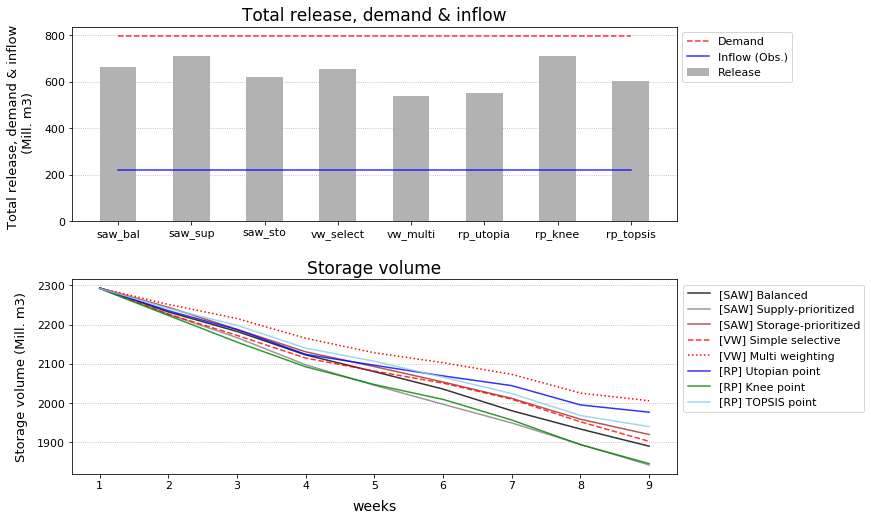

In [14]:
scenario = 5  # 1: Perfect forecast, 2: worst case, 3: 20-year drought, 4: ESP, 5: SFFs

# Run get_results function
release, inflow, demand, storage = get_results(scenario, decision_time)
# Convert each data to dataframe
rel = pd.DataFrame(list(release.items()), columns=['method', 'release'])
dem = pd.DataFrame(list(demand.items()), columns=['method', 'demand'])
inf = pd.DataFrame(list(inflow.items()), columns=['method', 'inflow'])
sto = pd.DataFrame(storage)


fig, axes = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(13, 3.8 * 2))
bar_width = 0.5  # Set the width of the bars
index = np.arange(1, decision_time * 4 + 2)  # Set the x-axis positions

# First subplot: Total release and demand
plt.subplot(2,1,1)

# Create a bar plot for total release values
plt.bar(rel['method'], rel['release'], label='Release', color='grey', alpha=0.6, width=bar_width)
# Plot the demand values as a line plot
plt.plot(dem['method'], dem['demand'], label='Demand', color='red', linestyle='--', alpha=0.8)
plt.plot(inf['method'], inf['inflow'], label='Inflow (Obs.)', color='blue', alpha=0.8)

# Set the title and labels for the first subplot
plt.title('Total release, demand & inflow', fontsize = 17)
plt.ylabel('Total release, demand & inflow \n (Mill. m3)', fontsize=13, labelpad=9)
# Adjust tick parameters for x and y axes
plt.tick_params(axis='x', labelsize=11)
plt.tick_params(axis='y', labelsize=11)
# Add a grid for the y-axis with dotted lines
plt.grid(True, axis='y', linestyle=':')
# Add a legend with fontsize 11, positioned to the upper right
plt.legend(fontsize=11, loc='upper right', bbox_to_anchor=(1.20,1.0))


# Second subplot: Storage volume
plt.subplot(2,1,2)

# Plot different storage volume values with various line styles and colors
plt.plot(sto.index+1, sto['saw_bal'], label='[SAW] Balanced', color='black', alpha=0.8)
plt.plot(sto.index+1, sto['saw_sup'], label='[SAW] Supply-prioritized', color='grey', alpha=0.8)
plt.plot(sto.index+1, sto['saw_sto'], label='[SAW] Storage-prioritized', color='brown', alpha=0.8)
plt.plot(sto.index+1, sto['vw_select'], label='[VW] Simple selective', color='red', alpha=0.8, linestyle='--')
plt.plot(sto.index+1, sto['vw_multi'], label='[VW] Multi weighting', color='red', alpha=1, linestyle=':')
plt.plot(sto.index+1, sto['rp_utopia'], label='[RP] Utopian point', color='blue', alpha=0.8)
plt.plot(sto.index+1, sto['rp_knee'], label='[RP] Knee point', color='green', alpha=0.8)
plt.plot(sto.index+1, sto['rp_topsis'], label='[RP] TOPSIS point', color='skyblue', alpha=0.8)

# Set the title and labels for the second subplot
plt.title('Storage volume', fontsize = 17)
plt.ylabel('Storage volume (Mill. m3)', fontsize=13, labelpad=9)
plt.xlabel('weeks', fontsize=14, labelpad=9)
# Adjust tick parameters for x and y axes
plt.tick_params(axis='x', labelsize=11)
plt.tick_params(axis='y', labelsize=11)
# Add a legend with fontsize 11, positioned to the upper right
plt.legend(fontsize=11, loc='upper right', bbox_to_anchor=(1.32,1.0))
# Add a grid for the y-axis with dotted lines
plt.grid(True, axis='y', linestyle=':')

# Adjust the layout to ensure no overlap and add padding between subplots
plt.tight_layout(pad=2)
# Display the plots
plt.show()